##This notebook looks for which OTUs are significantly enriched or depleted as compared to the first sampling date. It accounts for the effects of which site each sample came from, but does not report the effects for each sample site separately

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
# Loading matplot Python library
# Loading the Rmagic extension

ImportError: dlopen(/Users/michaeljbraus/anaconda/lib/python3.5/site-packages/rpy2/rinterface/_rinterface.cpython-35m-darwin.so, 2): Library not loaded: libicuuc.54.dylib
  Referenced from: /Users/michaeljbraus/anaconda/lib/python3.5/site-packages/rpy2/rinterface/_rinterface.cpython-35m-darwin.so
  Reason: image not found

In [3]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in after plyr
library(ggplot2)
library(doParallel)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [4]:
%%R
physeq = import_biom("OTU_table.biom", parseFunction = parse_taxonomy_greengenes)
# Importing the biom file as a phyloseq object, parsing its taxonomy as greengenes format

In [5]:
%%R
physeq
# Checking out the phyloseq object - we don't have the sample data added yet.

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 51928 taxa and 52 samples ]
tax_table()   Taxonomy Table:    [ 51928 taxa by 8 taxonomic ranks ]


In [6]:
%%R
sam.data <- read.csv(file="sample.data.csv", row.names=1, header=TRUE)
head(sam.data)
# Looking at the sample data file

       TreatmentGroup SampleSite Date                       Description
C172N1          Early      North J172 Sample of day 172 at site North 1
C172N2          Early      North J172 Sample of day 172 at site North 2
C172N3          Early      North J172 Sample of day 172 at site North 3
C172P1          Early      Point J172 Sample of day 172 at site Point 1
C172P2          Early      Point J172 Sample of day 172 at site Point 2
C172P3          Early      Point J172 Sample of day 172 at site Point 3


In [7]:
%%R
sample_data(physeq) <- sam.data
physeq
#Now we have added the sample data to the phylosq object.

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 51928 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 51928 taxa by 8 taxonomic ranks ]


In [8]:
%%R
sample.summary <- data.frame(sample_data(physeq)) %>%
    group_by(SampleSite,Date) %>%
    summarize(total=n())
sample.summary
# Takes the sample data we just connected to the phyloseq file, in the form of a dataframe,
# Groups it by each combination of sample site and date
# reports the total number of samples we have for each site/date combo - we have 2-3 samples for each.

Source: local data frame [18 x 3]
Groups: SampleSite

   SampleSite Date total
1       North J172     3
2       North J178     3
3       North J185     3
4       North J199     3
5       North J206     3
6       North J214     3
7       Point J172     3
8       Point J178     3
9       Point J185     3
10      Point J199     3
11      Point J206     2
12      Point J214     3
13      South J172     3
14      South J178     3
15      South J185     3
16      South J199     3
17      South J206     2
18      South J214     3


In [9]:
%%R
# Creating a matrix with the different combinations of variables for samplesite and date
#variables = expand.grid(SampleSite=levels(sample.summary$SampleSite),Date=levels(sample.summary$Date))
variables = expand.grid(Date=levels(sample.summary$Date))
variables

  Date
1 J172
2 J178
3 J185
4 J199
5 J206
6 J214


In [10]:
%%R
# We are creating a function called Dif_Abund that will run deseq on each subset of factors (day and samplesite), 
# and return the factors, OTU ID, base mean, log2-fold change, the SE, and the p value associated with the response.

Dif_Abund = function(Date){
    physeq.pruned = prune_samples(((sample_data(physeq)$Date == Date) | (sample_data(physeq)$Date == "J172")),physeq)
# Pulling out the samples we want to compare - we will run DESeq for each date. So, we pull out the rows from the date we are interested in,
# and then also the baseline date (J172), from our physeq object.
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
# Cutting out any OTUs that don't show up in this comparison
    taxonomy <- data.frame(tax_table(physeq.pruned))
# Storing the taxonomy data
    dseq = phyloseq_to_deseq2(physeq.pruned, ~SampleSite+Date)
# Creating the dseq file, and using the formula that tells it we are interested in samplesite as a factor, and date as the baseline.
    dseq$Date = relevel(dseq$Date,"J172")
# Establishing that the baseline comparison is for the first day.
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
# Running the actual DESeq function
    results = results(dseq, cooksCutoff=TRUE)
# Reporting the results from the dseq object we just created
# You can change Cooks Cutoff to control outliers (TRUE) or not (FALSE)
    results$Date = Date
# Creates a column in the results dataframe listing the SampleSite
    results = data.frame(results$Date,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
# Pulling out all the results we are actually interested in
    colnames(results) = c("Date","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
# Naming the columns appropriately
    results
# Return the final results dataframe
    }

In [11]:
%%R
DA<-mdply(as.character(variables[2:6,]),Dif_Abund)
# Runs the  differential abundance function we created above on all the combinations of variables
# We are leaving out the first variable, because that is the comparison baseline.
# The formula, as written above, will not tell us if the sites are different from one to the next
# It is looking for OTUs that are increased in relative abundance (compared to the first sampling day)
# across all sites, but accounting for the fact that the sites have different baselines, basically.

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [12]:
%%R
threshold = function (thresh){
    filter(DA, baseMean >= thresh) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>%
    summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Creates a function called "threshold" that will take our DA table as created above, then filter it so that we only keep
# rows where the baseMean (roughly the relative abundance for that OTU) is greater than some threshold, "thresh"
# Then, for those remaining rows, we run a Benjamini-Hochberg correction on our p-values, outputting these adjusted
# values in a new colum ("padj")
# Finally, we report back the threshold, and then the sum of taxa for which we have adjusted p values
# less than or equal to 0.10, our chosen false discovery rate

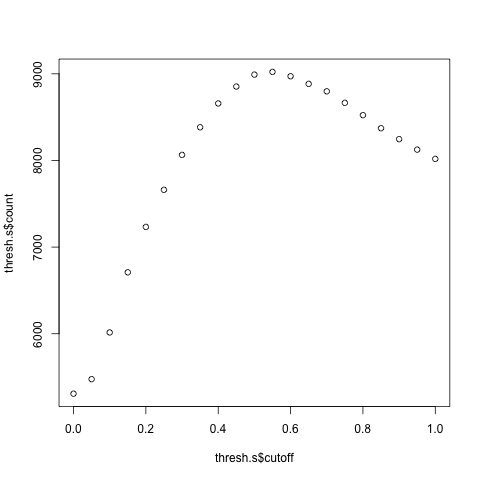

In [13]:
%%R
range = seq(0,1,0.05)
# Creates a sequence of numbers we are interested in for adjusted p values (from 0-1 by 0.05 increments)
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.55)

In [15]:
%%R
head(DA)

  X1 Date             OTU    baseMean       l2FC        SE       pvalue
1  1 J178 KC886811.1.1420  7.43631616  1.0892497 0.6923218 0.1156427257
2  1 J178 FJ612183.1.1494 20.29017727  2.2608386 0.6687068 0.0007224579
3  1 J178 FJ382737.1.1359  0.14167739  0.3569582 1.3233962 0.7873688482
4  1 J178 HQ789136.1.1428  0.09865447 -1.2551138 1.2770055 0.3256777940
5  1 J178 AM419442.1.1418  3.76110967 -0.5811535 0.9325650 0.5331679016
6  1 J178 AF368182.1.1369  1.89094429  1.2420242 0.9296496 0.1815449624
   Kingdom         Phylum               Class              Order
1 Bacteria  Bacteroidetes      Flavobacteriia   Flavobacteriales
2 Bacteria Proteobacteria  Betaproteobacteria    Burkholderiales
3 Bacteria  Cyanobacteria         Chloroplast      Stramenopiles
4 Bacteria Proteobacteria Gammaproteobacteria     Pasteurellales
5 Bacteria Proteobacteria Deltaproteobacteria Desulfovibrionales
6 Bacteria Proteobacteria Alphaproteobacteria    Rhodobacterales
               Family            Genus   

In [16]:
%%R
group_by(DA, Date) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=0.55) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above ("DA"), and take the sum of the baseMean for each date
# Then we filter the whole set of values to include only those OTUs for which their baseMean sum was >0.55,
# We then adjust the p values only for those that we expect might be significant.
# I.e., those of very low relative abundance in the first place are not getting assessed at all,
# Allowing us to not test their significance - so untestested values will have NA in the padj column.
# Then we save it as a csv.

In [26]:
%%R
l2fc<-read.csv("l2fc.csv")
# Import that csv file we just saved
dim(l2fc[is.na(l2fc$padj)==TRUE,])[1]/dim(l2fc[])[1]
# Fraction of OTUs that were not tested for significance (padj is "NA")
# We didn't actually cut it down that much, but it might help.

[1] 0.04251047


In [31]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(Date)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(Date)%>%
    count(Date,Sig)%>%
    group_by(Date)%>%
    mutate(Fraction=n/sum(n))
d
# Creates a little table showing which fraction of OTUs were designated as significant or not on each date
# A good number are - 10-30%

Source: local data frame [10 x 4]
Groups: Date

   Date Sig    n   Fraction
1  J178   0 3850 0.90716305
2  J178   1  394 0.09283695
3  J185   0 3619 0.83541090
4  J185   1  713 0.16458910
5  J199   0 3478 0.76523652
6  J199   1 1067 0.23476348
7  J206   0 3969 0.75327387
8  J206   1 1300 0.24672613
9  J214   0 3553 0.70833333
10 J214   1 1463 0.29166667


In [32]:
%%R
head(l2fc)

  X1 Date             OTU   baseMean       l2FC        SE       pvalue  Kingdom
1  1 J178 KC886811.1.1420  7.4363162  1.0892497 0.6923218 0.1156427257 Bacteria
2  1 J178 FJ612183.1.1494 20.2901773  2.2608386 0.6687068 0.0007224579 Bacteria
3  1 J178 AM419442.1.1418  3.7611097 -0.5811535 0.9325650 0.5331679016 Bacteria
4  1 J178 AF368182.1.1369  1.8909443  1.2420242 0.9296496 0.1815449624 Bacteria
5  1 J178   E32645.1.1435  1.4663138 -1.6768601 1.1289270 0.1374491754 Bacteria
6  1 J178 FJ382078.1.1219  0.6253231 -0.2962671 0.9961771 0.7661580835 Bacteria
          Phylum               Class              Order              Family
1  Bacteroidetes      Flavobacteriia   Flavobacteriales   Flavobacteriaceae
2 Proteobacteria  Betaproteobacteria    Burkholderiales    Oxalobacteraceae
3 Proteobacteria Deltaproteobacteria Desulfovibrionales Desulfomicrobiaceae
4 Proteobacteria Alphaproteobacteria    Rhodobacterales    Rhodobacteraceae
5  Cyanobacteria         Chloroplast        Chlorophyta     

In [93]:
%%R 
FDR = 0.1
d = l2fc

d = group_by(d, Date) %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(padj != 'NA')
# Creates a column designating whether (1) or not (0) the padj is lower than our false discovery rate (set above)
# We also calculate a new relative abundance value using the average across samples
# and we cut out those rows with no p-values

PhylumFraction = 0.005
OTUFraction = 0.001
PhylumList = d %>%
    group_by(Phylum,Date)%>%
    filter(sum(relabund)>=PhylumFraction | relabund>=OTUFraction)
PhylumList = levels(droplevels(PhylumList$Phylum))
# Looks at each phylum, on each date, and sees if the total abundance of OTUs within that phylum is
# greater than the cutoff (PhylumFraction, defined above), OR if the single OTU makes up a large enough fraciton
# of the total community on its own (OTUFraction, defined above)
# Thus, we have selected the phyla we want to plot.

d = filter(d, Phylum %in% PhylumList)
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# makes a dataframe with the maximum value of log2Fold change for each phylum
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$sig = as.factor(d$sig)
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
# Creates new columns (true/false) for whether it is significant or not

##Let's take a look at how relative abundance changes over time (in all 3 sites combined) within each phylum

Scale for 'size' is already present. Adding another scale for 'size', which will replace the existing scale.


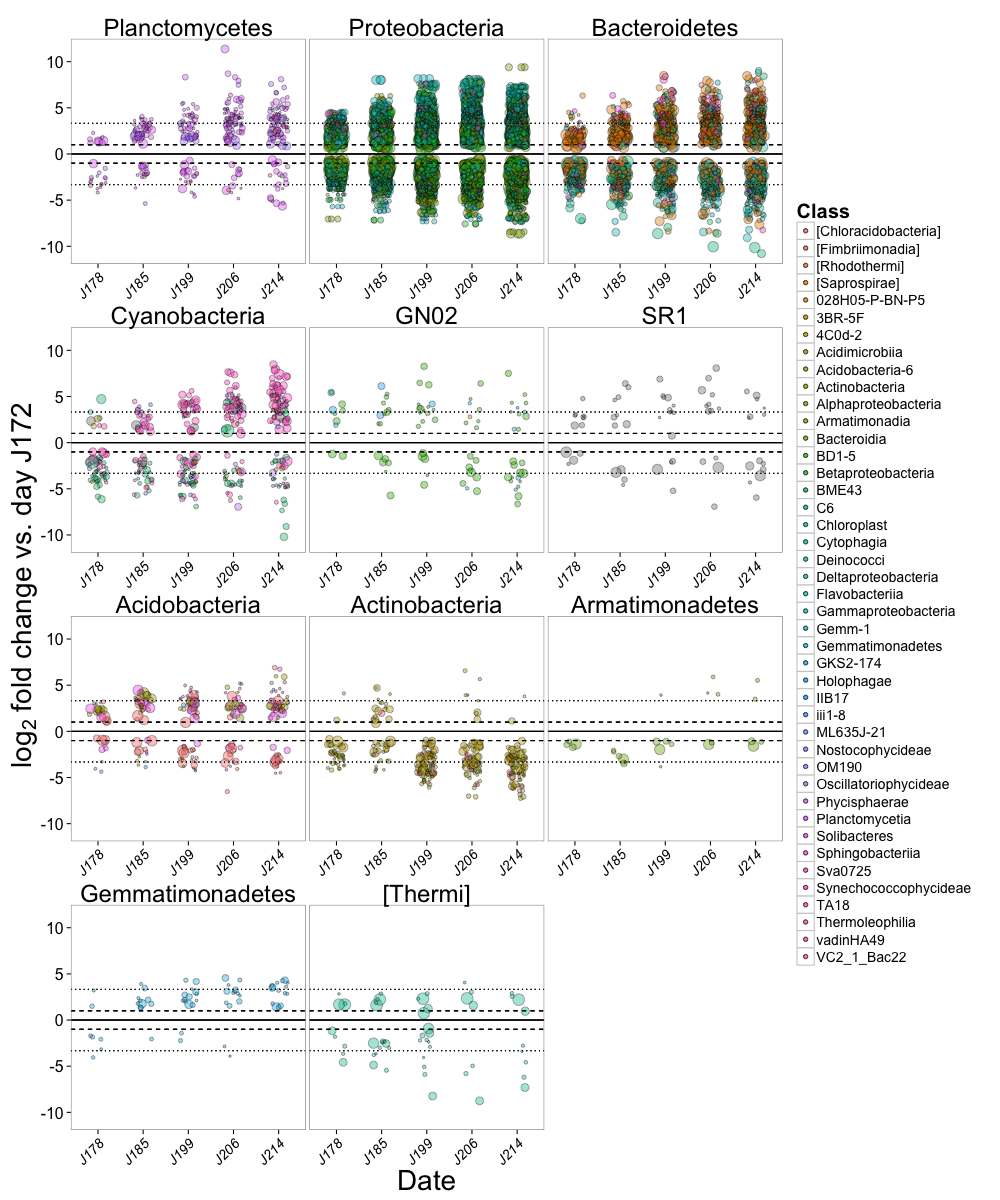

In [117]:
%%R -w 1000 -h 1200
# setting the image sizes, then making the figure...

p = p + geom_point(data=d.yes, aes(x = Date, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# p = p + geom_point(data=d.no, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_wrap(~Phylum, scales="free_x",ncol=3)
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

##The Proteobacteria and Bacteroidetes are too rich to really see clearly at the phylum level, so we plot them out below

Scale for 'size' is already present. Adding another scale for 'size', which will replace the existing scale.


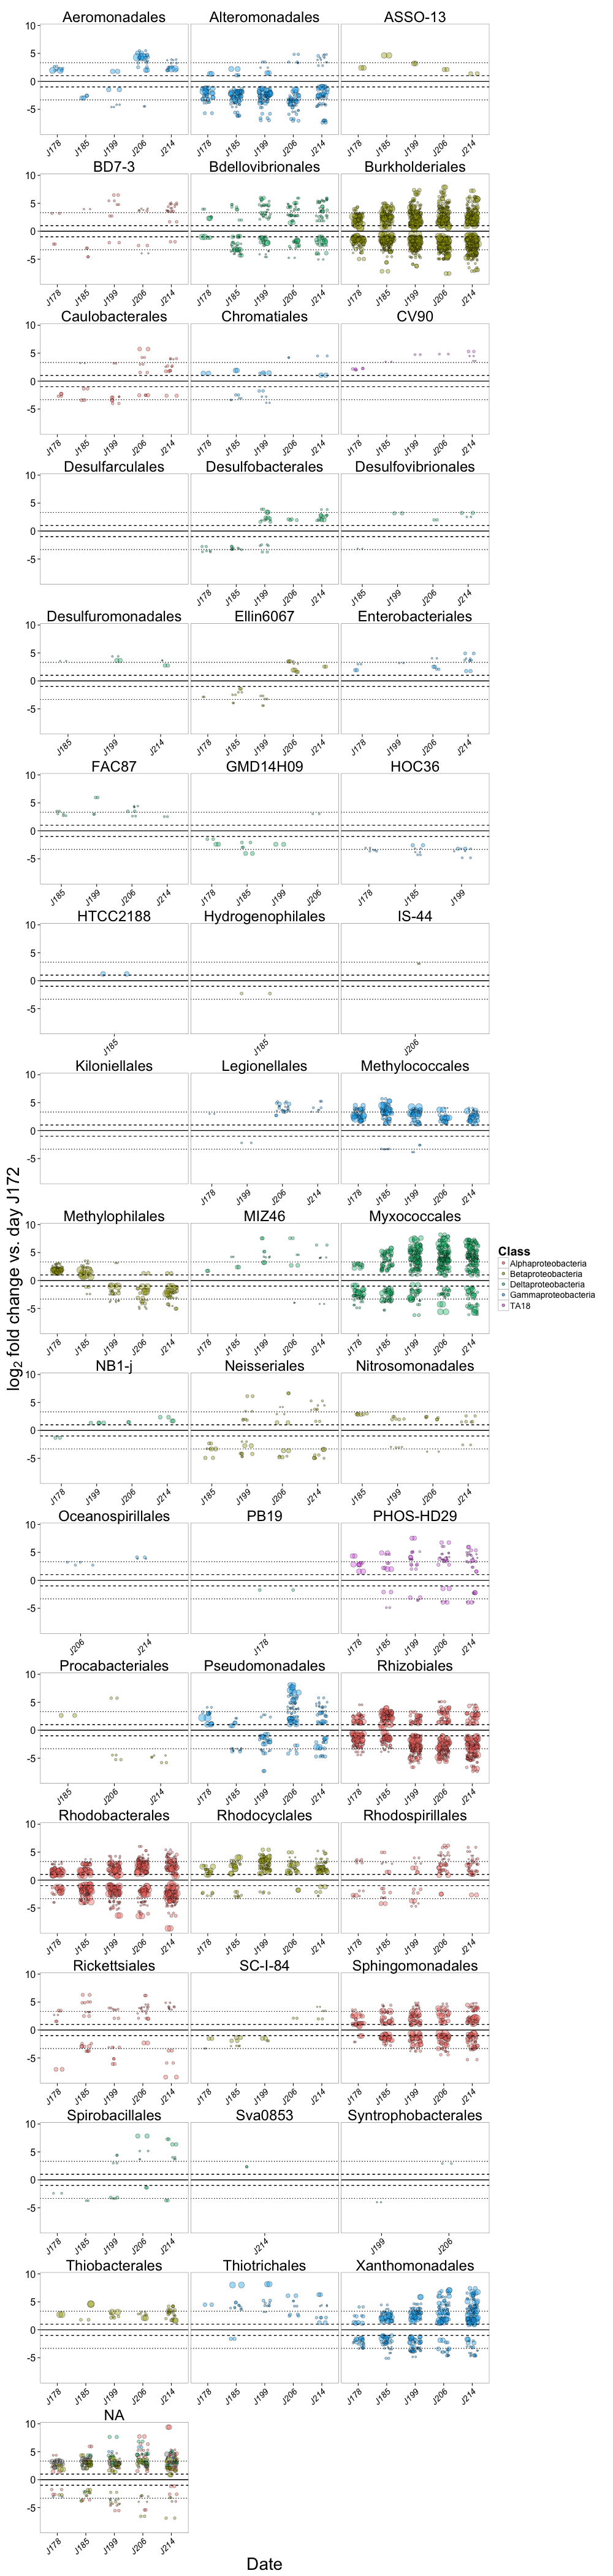

In [116]:
%%R -w 1000 -h 4200
# setting the image sizes, then making the figure...

d.yesProteo = d.yes %>%
    filter(Phylum=="Proteobacteria")
d.noProteo = d.no %>%
    filter(Phylum=="Proteobacteria")
# Subsetting our data for Proteos


p = p + geom_point(data=d.yesProteo, aes(x = Date, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# p = p + geom_point(data=d.noProteo, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_wrap(~Order, scales="free_x",ncol=3)
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

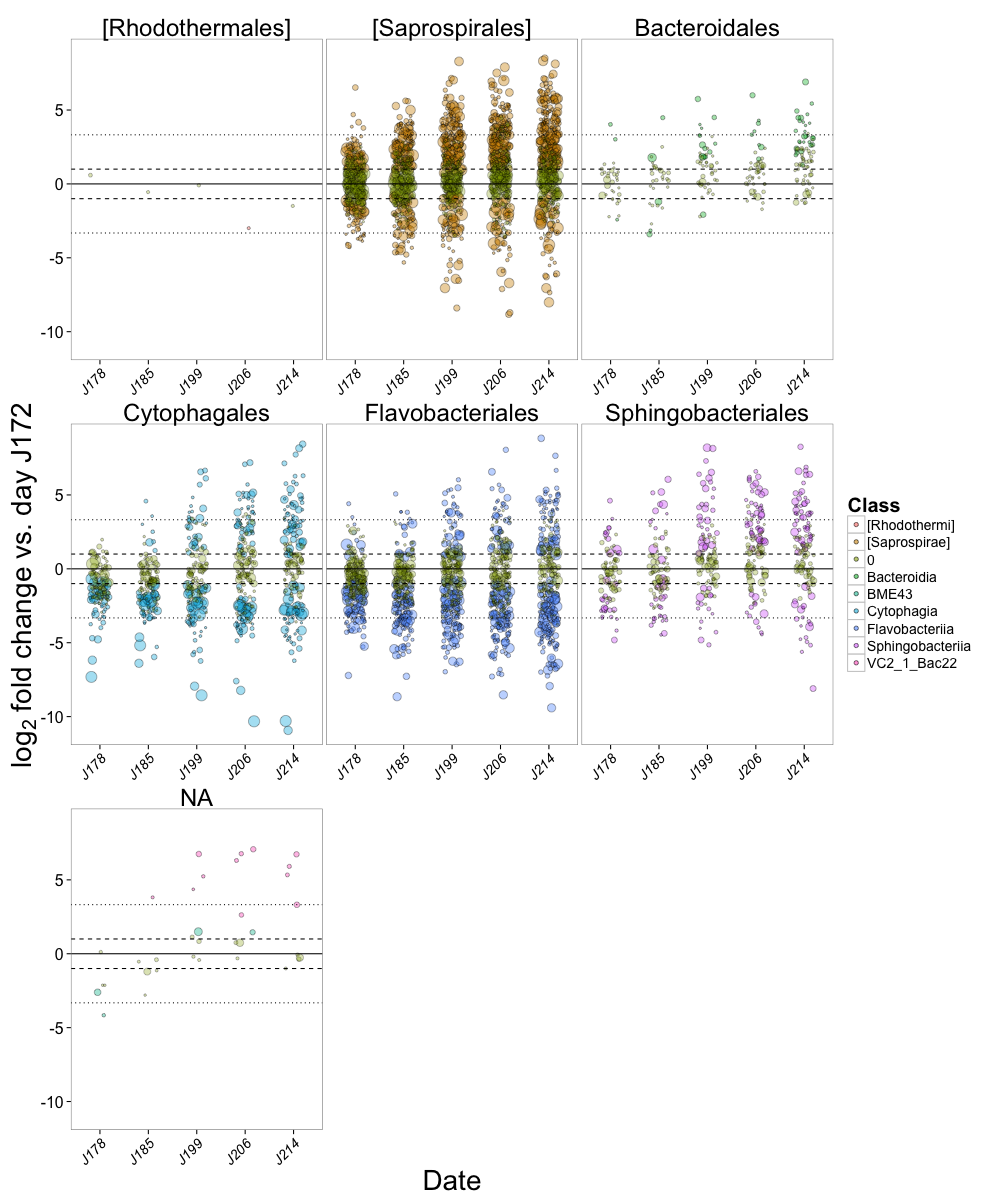

In [110]:
%%R -w 1000 -h 1200
# setting the image sizes, then making the figure...

d.yesBacter = d.yes %>%
    filter(Phylum=="Bacteroidetes")
d.noBacter = d.no %>%
    filter(Phylum=="Bacteroidetes")

p = p + geom_point(data=d.yesBacter, aes(x = Date, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.noBacter, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_wrap(~Order, scales="free_x",ncol=3)
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

##The methanos

In [129]:
%%R
# Find methanotrophs
methanolist <- read.table(file = "methanos.txt")
methanolist <- as.vector(methanolist$V1)
# Create a list of all the possible methanotroph genera
df = l2fc %>%
 filter(Genus %in% as.factor(methanolist))
# Take out only the methanotrophs

df = df %>%
    group_by(Date) %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    mutate(Total=sum(baseMean)) %>%
    mutate(relabund=baseMean/Total)%>%
    filter(padj != 'NA')
# Creates a column designating whether (1) or not (0) the padj is lower than our false discovery rate (set above)
# We also calculate a new relative abundance value using the average across samples
# and we cut out those rows with no p-values

df$sig = as.factor(df$sig)
df.yes = df[df$sig==1,]
df.no = df[df$sig==0,]
# Creates new columns (true/false) for whether it is significant or not

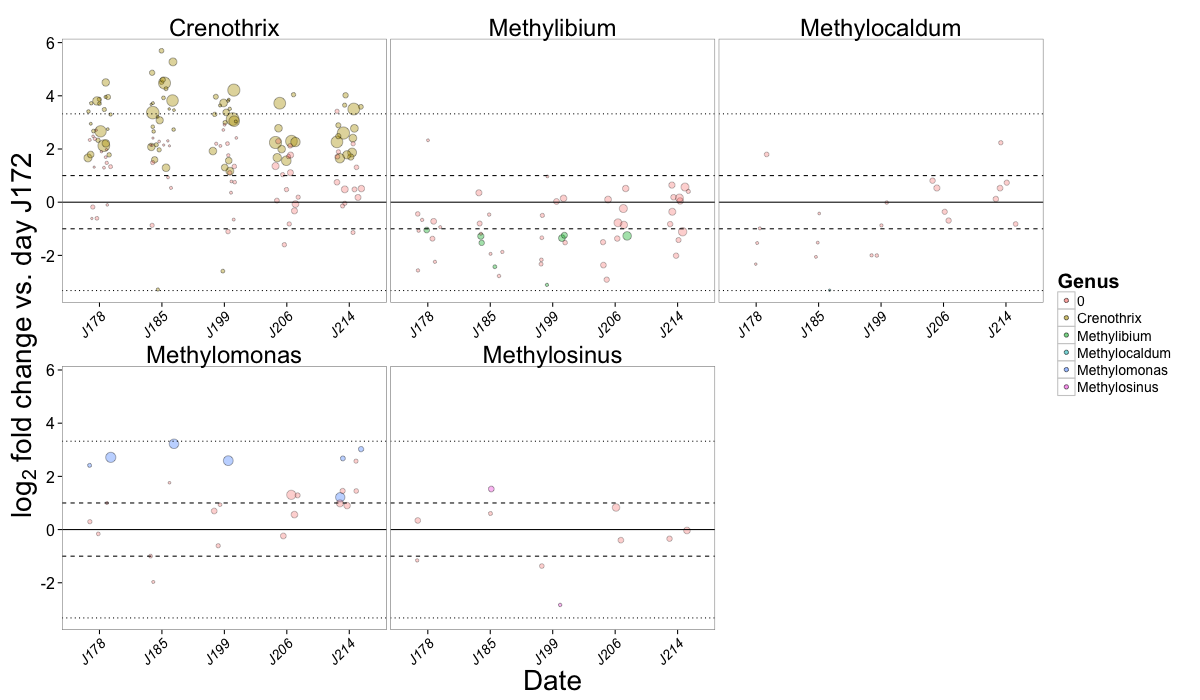

In [134]:
%%R -w 1200 -h 700

p = ggplot(df)

p = p + geom_point(data=df.yes, aes(x = Date, y = l2FC, fill = Genus, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=df.no, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_wrap(~Genus, scales="free_x", ncol=3)
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes

p 

##In general, we can see that Crenothrix seemed to be increased compared to the first sampling date, but this was across days. Methylibium decreased, while Methylomonas increased.